# CS229: Problem Set 1
## Problem 5: Regression for denoising quasar spectra

**C. Combier**

This iPython Notebook provides solutions to Stanford's CS229 (Machine Learning, Fall 2017) graduate course problem set 1, taught by Andrew Ng.

The problem set can be found here: [./ps1.pdf](ps1.pdf)

I chose to write the solutions to the coding questions in Python, whereas the Stanford class is taught with Matlab/Octave.

## Notation

- $x^i$ is the $i^{th}$ feature vector
- $y^i$ is the expected outcome for the $i^{th}$ training example
- $m$ is the number of training examples
- $n$ is the number of features

Let's start by setting up our Python environment and importing the required libraries:

In [1]:
%matplotlib inline
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes

#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns #sets up styles and gives us more plotting optionsimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')

### Question 5.a.i)

This question simply consists in vectorizing the equation defining $J$:

$$
\begin{align*}
J(\theta) &= \frac{1}{2} \sum_{i=1}^m w^i (\theta^T x^i - y^i)^2 \\
&= \frac{1}{2} \sum_{i=1}^m (\theta^T x^i - y^i) w^i (\theta^T x^i - y^i) \\
&= \frac{1}{2} (X \theta - y)^T W (X \theta - y)
\end{align*}
$$

Where $W = diag(w^i)$.

### Question 5.a.ii)

Now that we have derived a vectorized definition for $J$, the normal equations are obtained by calculating $\nabla_{\theta} J$. 

$$
\begin{align*}
\nabla_{\theta} J &= X^T W (X \theta - Y)
\end{align*}
$$

Set the gradient to $0$ to obtain the normal equations:

$$
\begin{align*}
\nabla_{\theta} J &= 0 \\
X^T W (X \theta - Y) &=0 \\
X^T W X \theta &= X^T W Y \\
\theta &= (X^T W X)^{-1} X^T W Y
\end{align*}
$$

### Question 5.a.iii)

Let's calculate the log-likelihood and use it to obtain the maximum likelihood estimate for $\theta$. Since we are interested in the gradient of the log-likelihood, we will drop constant terms that are independant of $\theta$

$$
\begin{align*}
\ell (\theta) & = \sum_i^m \log p(y^i | x^i; \theta) \ \\
& \approx - \sum_i^m \frac{(y^i - \theta^T x^i)^2}{2 {\sigma^i}^2} \\
& = -\frac{1}{2}\sum_i^m \frac{(y^i - \theta^T x^i)^2}{ {\sigma^i}^2}
\end{align*}
$$

Maximizing $\ell (\theta)$ is equivalent to minimizing $\frac{1}{2}\sum_i^m \frac{(y^i - \theta^T x^i)^2}{\sigma^2}$.

We recognize the form of $J$, with weights $w^i = \frac{1}{ {\sigma^i}^2}$

We are now ready to import the data and take a quick peek:

In [3]:
df_train = pd.read_csv('./data/quasar_train.txt', )
cols_train = df_train.columns.values.astype(float).astype(int)
df_train.shape
df_train.head()

,1150.000,1151.000,1152.000,1153.000,1154.000,1155.000,1156.000,1157.000,1158.000,1159.000,1160.000,1161.000,1162.000,1163.000,1164.000,1165.000,1166.000,1167.000,1168.000,1169.000,1170.000,1171.000,1172.000,1173.000,1174.000,1175.000,1176.000,1177.000,1178.000,1179.000,1180.000,1181.000,1182.000,1183.000,1184.000,1185.000,1186.000,1187.000,1188.000,1189.000,1190.000,1191.000,1192.000,1193.000,1194.000,1195.000,1196.000,1197.000,1198.000,1199.000,...,1550.000,1551.000,1552.000,1553.000,1554.000,1555.000,1556.000,1557.000,1558.000,1559.000,1560.000,1561.000,1562.000,1563.000,1564.000,1565.000,1566.000,1567.000,1568.000,1569.000,1570.000,1571.000,1572.000,1573.000,1574.000,1575.000,1576.000,1577.000,1578.000,1579.000,1580.000,1581.000,1582.000,1583.000,1584.000,1585.000,1586.000,1587.000,1588.000,1589.000,1590.000,1591.000,1592.000,1593.000,1594.000,1595.000,1596.000,1597.000,1598.000,1599.000
0,0.629,1.910,0.976,2.161,0.964,2.068,1.630,1.716,2.378,-0.540,1.833,0.525,0.927,0.652,1.049,0.218,0.706,1.936,1.242,1.307,1.070,-0.141,1.032,1.099,2.043,2.046,1.187,1.118,-0.043,1.627,0.329,0.808,0.292,0.896,1.260,1.047,1.651,1.107,0.763,1.002,0.492,1.108,2.098,1.428,1.128,1.103,1.570,0.420,1.604,0.485,...,0.897,1.452,1.971,1.328,1.364,0.958,1.299,1.562,1.482,1.957,1.565,1.206,0.475,0.781,1.248,0.594,1.327,1.581,-0.077,1.850,2.088,0.684,0.812,0.087,1.099,0.743,1.523,2.168,0.932,1.694,1.705,2.074,0.819,1.573,1.151,0.668,0.993,1.675,1.520,1.369,0.532,1.462,0.323,2.515,1.194,0.654,1.056,1.450,0.203,0.382
1,-0.161,1.830,0.609,1.932,0.932,0.857,0.978,1.032,1.793,1.455,1.230,-0.757,-0.022,2.332,2.036,1.422,1.672,0.041,1.507,0.806,1.031,0.860,1.085,1.364,1.849,1.304,0.528,0.748,2.684,0.169,0.801,0.843,1.252,1.561,1.541,0.363,1.339,1.338,1.167,1.806,1.471,0.732,0.705,0.408,1.428,0.898,0.380,1.201,0.807,0.928,...,1.294,1.116,0.943,2.086,1.099,1.899,1.919,1.166,0.202,1.429,1.237,1.819,1.186,1.727,0.796,1.252,0.574,0.903,1.185,1.557,-0.089,1.704,-0.521,1.653,0.328,1.178,1.612,1.711,1.316,1.075,2.438,0.890,1.370,1.821,1.286,1.060,0.719,1.300,0.348,1.429,0.961,1.407,1.296,0.943,1.055,2.265,1.053,1.439,0.767,-0.552
2,-0.085,-1.304,0.691,-0.800,-1.090,1.087,0.734,1.198,1.122,0.742,-0.768,0.686,0.668,1.415,0.480,0.708,-0.108,1.969,1.557,1.269,1.007,1.350,-0.292,1.582,1.148,0.298,1.313,0.967,2.838,1.264,0.221,1.620,0.799,0.850,1.192,1.662,0.955,0.544,1.559,1.011,0.566,0.635,0.418,1.436,0.519,1.339,1.296,0.675,0.289,0.447,...,1.042,0.818,1.628,1.249,1.726,0.804,1.164,1.646,2.282,2.607,2.054,1.029,1.114,1.644,1.511,1.009,0.872,1.621,1.869,1.805,2.821,0.362,2.096,2.159,0.139,0.244,1.962,0.366,2.405,1.696,0.855,0.812,1.090,1.056,1.215,1.062,0.775,1.407,1.177,0.774,0.447,1.139,0.422,1.248,1.047,0.500,1.514,1.623,1.202,0.924
3,1.283,-0.487,0.660,0.167,-1.217,1.535,2.264,0.220,0.865,-0.723,2.689,0.596,0.616,1.072,1.111,1.274,0.802,0.572,2.442,1.093,1.964,0.212,-0.086,1.391,2.548,0.917,0.958,0.626,1.162,1.192,0.915,0.850,1.469,-0.040,1.260,1.429,0.701,1.028,0.403,1.257,0.270,0.638,2.566,-0.237,0.191,0.151,0.969,1.614,0.293,1.210,...,0.528,1.016,1.021,2.254,0.044,0.997,1.608,0.507,0.225,1.962,1.541,1.184,1.566,1.330,0.700,0.851,0.707,1.403,0.520,2.310,1.212,1.425,1.567,1.224,2.483,0.956,1.167,-0.389,0.821,0.763,0.661,0.694,1.547,1.815,0.949,0.896,1.809,-0.288,0.742,1.161,0.714,1.173,1.579,0.477,0.781,0.525,2.466,1.493,1.503,0.698
4,-0.107,0.328,0.681,2.500,0.083,1.876,2.359,1.122,0.584,0.835,-0.520,2.463,0.987,1.104,0.636,1.297,0.001,1.622,2.311,0.796,0.639,2.143,1.774,0.138,2.328,0.537,1.395,0.851,0.327,-0.084,1.779,0.907,1.054,0.588,1.286,0.539,1.743,0.995,0.641,0.935,1.365,0.954,0.801,0.493,1.285,0.972,0.507,1.053,1.328,1.360,...,0.632,1.042,0.947,0.778,0.329,1.381,1.332,1.666,2.192,1.155,1.146,1.656,1.633,1.628,0.781,1.340,1.213,1.406,1.194,0.347,1.477,1.194,0.528,2.039,1.674,0.893,1.254,1.313,0.787,1.598,1.057,1.823,2.430,2.218,1.275,1.009,1.722,0.404,1.614,0.785,1.427,2.685,1.152,1.365,0.280,2.246,1.249,1.304,0.578,0.831


In [4]:
df_test = pd.read_csv('./data/quasar_test.txt', )
cols_test = df_train.columns.values.astype(float).astype(int)

assert(cols_train == cols_test).all()

df_train.columns = cols_train
df_test.columns = cols_test
df_test.head()

,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,...,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
0,0.025,1.460,-0.057,1.37,2.090,1.150,-0.182,0.351,1.57,1.970,0.201,-1.12,1.920,1.080,0.760,1.490,0.655,1.860,1.030,0.965,1.07,0.946,0.788,1.730,1.56,1.140,1.16,0.556,0.434,0.291,0.940,1.360,1.390,0.634,1.080,0.961,1.890,1.320,2.100,0.470,1.03,1.400,0.513,0.398,1.030,1.180,1.55,0.971,0.497,1.200,...,0.973,1.200,0.923,1.080,0.037,0.889,1.480,1.940,1.020,0.322,0.293,1.750,1.450,1.500,1.67,1.070,0.740,0.713,1.080,0.977,0.082,1.40,0.879,1.14,0.369,1.730,0.917,1.630,1.370,1.000,0.600,1.570,0.850,1.110,0.539,1.050,0.557,1.510,1.750,0.597,0.525,0.574,1.570,1.280,0.963,1.04,1.160,0.555,0.733,1.180
1,1.210,0.375,0.695,-0.09,0.275,-0.128,0.043,-0.054,1.40,1.950,0.413,-0.26,0.989,2.070,1.690,1.140,1.670,1.510,0.973,1.630,1.62,1.280,0.109,1.910,1.63,0.912,1.76,1.160,-0.115,1.070,0.994,0.961,-0.440,0.062,0.229,1.380,1.700,0.935,0.126,0.652,1.24,1.300,1.230,1.380,1.250,1.210,1.66,1.520,0.056,0.973,...,1.580,0.728,0.934,1.410,1.090,1.540,1.020,1.300,1.170,1.470,1.560,1.540,1.260,1.340,1.02,1.600,0.807,1.910,0.242,0.759,1.080,1.60,-1.090,1.98,1.530,1.810,1.180,1.510,0.859,1.970,1.300,0.676,0.342,1.350,1.200,1.270,0.810,1.220,1.120,1.380,0.658,0.579,1.670,1.230,1.230,1.19,1.220,0.932,1.280,0.338
2,1.380,-0.436,2.700,1.18,1.850,0.374,2.290,1.110,1.06,1.270,0.647,2.00,-0.665,0.831,2.340,0.038,2.660,0.886,0.209,1.820,0.34,-0.005,0.997,1.790,1.52,0.425,1.23,0.898,-0.078,1.760,0.312,1.090,0.627,1.340,0.726,0.896,0.403,1.760,1.160,0.668,0.87,0.908,0.725,0.584,0.845,1.080,1.47,1.160,1.560,1.020,...,1.470,1.230,-0.362,0.931,1.400,1.540,2.070,1.620,-0.699,-0.214,2.300,1.230,0.872,1.250,2.13,1.130,1.640,0.854,0.687,1.560,1.880,1.65,0.217,-1.16,1.010,0.847,0.390,0.595,1.730,1.430,1.610,0.475,0.751,0.699,1.670,1.470,1.320,0.923,0.404,0.861,0.672,0.483,1.350,1.450,2.810,1.28,0.893,1.980,0.744,0.610
3,0.427,0.509,1.060,0.80,0.537,0.288,2.790,2.120,1.51,-0.937,0.710,2.32,1.630,-0.416,0.427,1.520,2.100,1.100,1.080,1.500,1.45,1.590,0.026,1.580,1.47,2.330,0.60,1.590,1.940,0.596,0.780,0.750,0.231,0.715,0.654,1.050,1.180,1.190,1.780,1.160,2.29,1.220,1.930,0.750,0.741,0.808,1.86,1.230,0.824,0.548,...,0.231,-0.159,1.120,1.690,1.420,2.510,-0.055,1.780,0.482,0.861,2.140,0.831,2.400,0.649,1.24,1.330,2.190,1.510,1.480,0.322,1.280,1.14,1.340,1.22,1.180,2.500,0.802,1.230,1.700,0.221,1.530,1.660,1.000,0.850,1.010,0.377,1.380,1.360,1.360,2.140,0.928,1.020,0.462,1.040,1.070,1.64,1.250,0.706,0.673,1.480
4,-0.371,0.773,-0.621,1.84,0.284,-0.009,1.910,1.900,1.64,0.803,0.941,1.27,1.570,0.772,1.860,1.110,2.720,1.100,1.810,1.490,1.79,0.428,1.600,0.076,1.24,0.572,2.29,1.000,1.270,0.788,1.750,1.260,0.527,1.140,1.160,0.808,1.680,1.030,1.300,0.867,1.27,0.645,1.550,0.966,1.700,0.773,1.78,2.180,1.200,0.885,...,1.150,1.560,1.540,0.940,1.390,1.030,1.550,-0.452,1.650,2.770,0.721,1.590,1.540,0.624,1.41,0.592,1.190,1.810,1.100,-0.171,1.090,0.64,1.090,0.87,2.320,0.014,0.473,1.410,1.050,0.562,0.069,0.968,1.070,1.750,1.100,-0.051,0.382,0.405,1.820,2.040,1.240,0.867,1.460,0.035,1.880,1.74,-0.225,0.711,-0.571,0.786


### Question 5.b.i)

In [5]:
def normal_equation(x, y, w=None):
    if w is None:
        return np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
    else:
        return np.linalg.inv(x.T.dot(w).dot(x)).dot(x.T).dot(w).dot(y)
    

In [6]:
def build_weights(x, x_i, tau=5):
    return np.diag(np.exp(-((x-x_i)[:,1]**2)/(2*tau**2)))

In [7]:
y=df_train.head(1).values.T
x=np.vstack((np.ones(cols_train.shape), cols_train)).T

In [9]:
theta = normal_equation(x,y)
print(theta.ravel())

[ 2.51339906e+00 -9.81122145e-04]


In [10]:
theta

array([[ 2.51339906e+00],
       [-9.81122145e-04]])

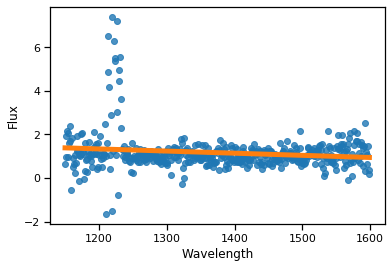

In [11]:
ax = sns.regplot(x=x[:,1], y=y, fit_reg=False);
plt.plot(x[:,1], x.dot(theta), linewidth=5);
ax.set(xlabel="Wavelength", ylabel='Flux');

### Question 5.b.ii)

In [19]:
np.exp(-((x-x[0,:])[:,1]**2)/(2*5.0**2)).shape

(450,)

In [25]:
pred = []
for k, x_j in enumerate(x):
    w = build_weights(x, x_j,5)
    theta = normal_equation(x, y, w)
    pred.append(theta.T.dot(x_j[:,np.newaxis]).ravel()[0])

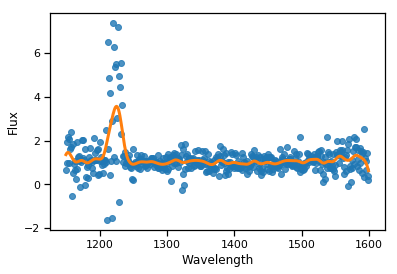

In [10]:
ax = sns.regplot(x=x[:,1], y=y, fit_reg=False);
plt.plot(x[:,1],pred,linewidth=3);
ax.set(xlabel="Wavelength", ylabel='Flux');

### Question 5.b.iii)

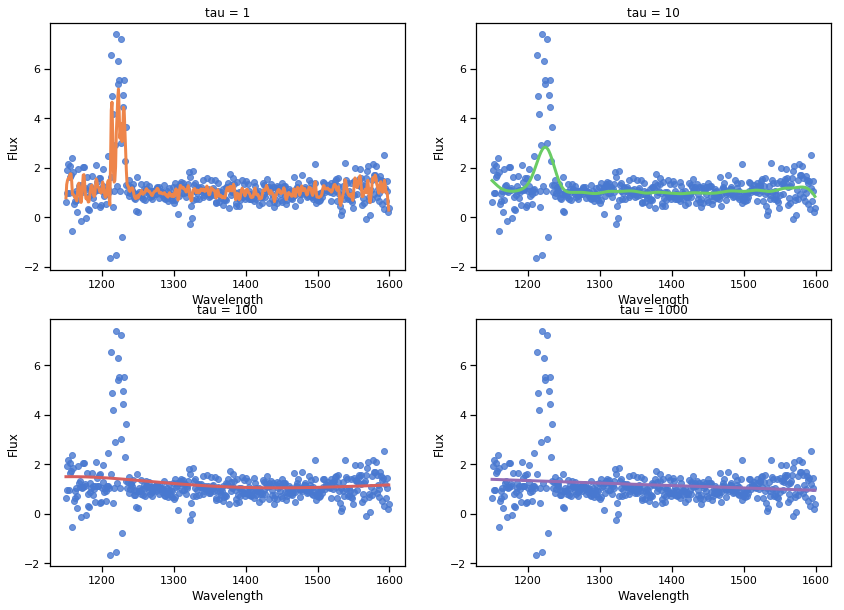

In [11]:
fig,axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.ravel()

# different palette
colors = sns.color_palette("muted")

#Loop through the values for tau
for k, tau in enumerate(np.logspace(0,3,4).astype(int)):
    pred = []
    ax=axes[k]
    # Calculate predictions
    for x_j in x:
        w = build_weights(x, x_j,tau)
        theta = normal_equation(x, y, w)
        pred.append(theta.T.dot(x_j[:,np.newaxis]).ravel()[0])
  
    # Plot results
    sns.regplot(x=x[:,1], y=y, fit_reg=False, ax=ax, color=colors[0]);
    ax.plot(x[:,1],pred,linewidth=3,color=colors[k+1]);
    ax.set(xlabel="Wavelength", ylabel='Flux', title='tau = {}'.format(tau));

- When $\tau$ is large, the weight matrix becomes close to the identity matrix (weights tend to one). In this case, weighted linear regression tends to behave like unweighted linear regression. The prediction is smooth.

- When $\tau$ is small, data points in the vicinity of the query point are heavily weighted, while data points farther away are less weighted. The prediction is therefore more sensitive to the data points in the vicinity of the query point, resulting in a noisier, less smooth prediction.

### Question 5.c.i)

In [20]:
y_train=df_train.values.T
y_test=df_test.values.T

In [21]:
def smoother(x,y_in,tau):
    pred = np.zeros(y_in.shape)
    for i in range(y_in.shape[1]):
        y = y_in[:,i]
        for j, x_j in enumerate(x):
            w = build_weights(x, x_j,tau)
            theta = normal_equation(x, y, w)
            pred[j][i] =  theta.T.dot(x_j[:,np.newaxis]).ravel()[0]
    return pred

In [22]:
y_train_smooth = smoother(x,y_train,5)
y_test_smooth = smoother(x,y_test,5)

In [23]:
y_train_smooth.shape

(450, 200)

In [24]:
y_test_smooth.shape

(450, 50)

In [76]:
y_train_smooth[0:3,:].T

array([[ 1.35457751,  1.411428  ,  1.44418291],
       [ 0.8630299 ,  0.93499234,  0.98748083],
       [-0.54199083, -0.3879195 , -0.23759803],
       [ 0.31531147,  0.35066741,  0.39968169],
       [ 0.55701048,  0.71910525,  0.84458201],
       [ 0.69789757,  0.74424111,  0.76562349],
       [ 1.04537124,  1.03496393,  1.02117741],
       [ 0.52013086,  0.57105724,  0.62860196],
       [ 0.40615345,  0.46198314,  0.52249446],
       [ 0.38137544,  0.50685178,  0.60261287],
       [ 1.01302133,  1.00436993,  0.98172846],
       [ 0.55022006,  0.63932935,  0.721485  ],
       [ 0.97811234,  0.97718597,  0.96687084],
       [ 0.53232309,  0.55838335,  0.58685354],
       [ 0.68215909,  0.82706817,  0.94362131],
       [ 1.46454835,  1.4063712 ,  1.33182718],
       [ 0.50358664,  0.64652466,  0.76357751],
       [ 1.09692075,  1.07507166,  1.05561847],
       [ 0.83735692,  0.88039615,  0.93062541],
       [ 0.89837811,  0.83721395,  0.7968702 ],
       [ 1.49556103,  1.29328882,  1.115

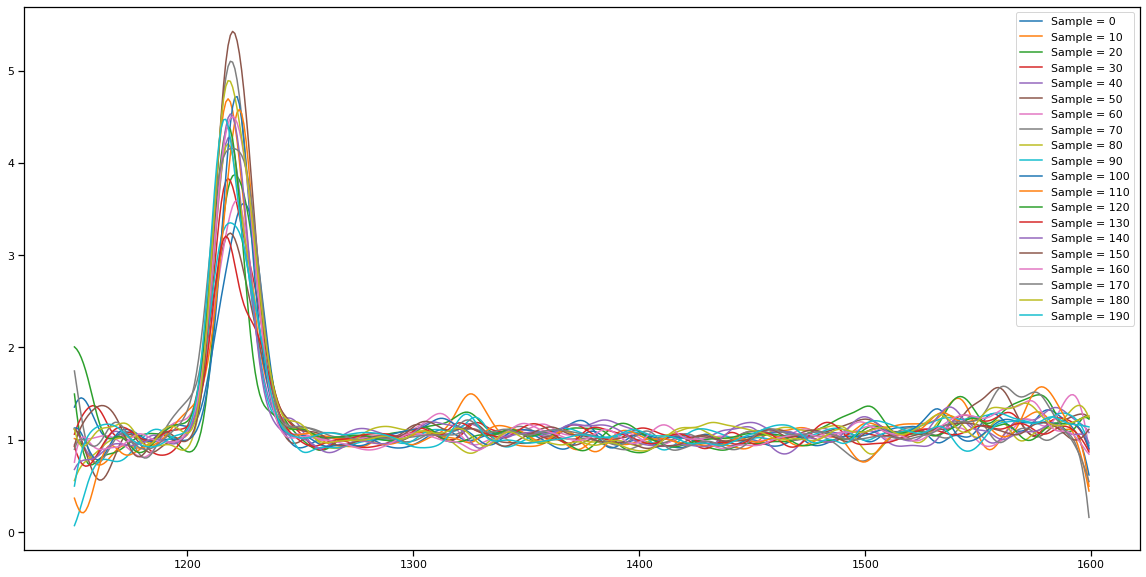

In [75]:
plt.figure(figsize=(20,10))
for i, y_i in enumerate(y_train_smooth.T):
    if i % 10 == 0 :
        plt.plot(x[:,1].T, y_train_smooth[:,i].T, label='Sample = '+str(i))
plt.legend()

### Question 5.c.ii)

In [26]:
def compute_delta(y,y_i):
    return np.sum((y-y_i[:,np.newaxis])**2,0)

In [27]:
def ker(t):
    return np.maximum(1-t,0)

In [28]:
def get_nearest_neighbors(y, i, deltas, k):
    max_d = deltas.max()
    #neighbs = pd_deltas.sort_values()[:k]
    #idx = [i for (i,d) in neighbs.iteritems()]
    idx = np.argsort(deltas)[:k+1]
    #idx = idx[idx != i]
    return idx[:k]

In [97]:
def func_regression(x, y_train, y_test, lyman_alpha):
    # Slice the training and test data according to Lyman-alpha
    y_train_left = y_train[x < lyman_alpha,:]
    y_train_right = y_train[x >= lyman_alpha+100,:]
    y_test_left = y_test[x < lyman_alpha,:]
    y_test_right = y_test[x >= lyman_alpha+100,:]

    # Format our estimate matrix to store results
    f_hat_left = np.zeros(y_test_left.shape)

    # Compute Distance Matrix
    for i in range(y_test_right.shape[1]):
        deltas = compute_delta(y_train_right, y_test_right[:,i])
        idx = get_nearest_neighbors(y_train_right,i,deltas,3)
        #print idx.shape
        h = np.max(deltas) 
        weights = ker(deltas/h)[idx]
        #print(f'deltas.shape={deltas.shape}')
        #print(f'weights.shape={weights.shape}')
        f_hat_num = np.sum(y_train_left[:,idx]*weights,1)
        #print(f'y_train_left[:,idx].shape={(y_train_left[:,idx]).shape}')
        #print(f'y_train_left[:,idx]*weights.shape={(y_train_left[:,idx]*weights).shape}')
        #print(f'f_hat_num.shape={f_hat_num.shape}')
        f_hat_den = np.sum(weights)
        f_hat = f_hat_num/f_hat_den
        print(f_hat_num[0:3])
        f_hat_left[:,i] = f_hat
    return f_hat_left

In [98]:
f_hat_train = func_regression(x[:,1],y_train_smooth,y_train_smooth,1200)

[2.4390088  2.52265299 2.59484885]
[3.13379174 3.26317359 3.33508394]
[1.24883762 1.50157497 1.72101919]
[0.31720308 0.60609127 0.88686716]
[1.74616677 2.07990999 2.36095021]
[2.03836004 2.24671321 2.38394618]
[2.21387131 2.32804858 2.40969417]
[2.29240723 2.29103481 2.29750065]
[2.28124036 2.31356001 2.35718348]
[1.5768384  1.85226725 2.07799841]
[1.0737589  1.28189249 1.48372468]
[1.31025602 1.69193975 2.0163456 ]
[3.17924715 3.11879393 3.05016062]
[1.26320055 1.29138324 1.34621752]
[1.91865721 2.11864081 2.26612576]
[2.35617666 2.27300054 2.20117   ]
[1.6938552  1.85516214 1.98717437]
[1.55098389 1.85248148 2.12076407]
[1.83459292 2.03114111 2.21742327]
[1.9369533  2.0932382  2.21649882]
[3.06042548 2.85854816 2.68955968]
[2.26520269 2.41674827 2.50837728]
[1.21000397 1.29355531 1.42289487]
[2.03192472 2.00658693 2.00591157]
[2.56089161 2.79288848 2.94405187]
[3.7911701  3.78891668 3.74410848]
[2.65014881 2.7010114  2.71746875]
[1.71812449 1.7087185  1.69793376]
[2.52348487 2.566677

Average Error between Training set and Estimate: 1.066


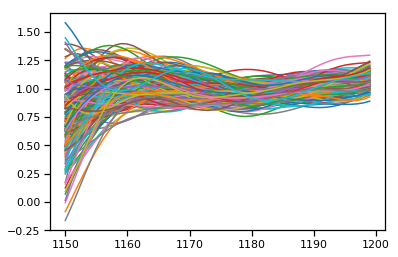

In [20]:
y_train_left = y_train_smooth[x[:,1] < 1200,:]
y_test_left = y_test_smooth[x[:,1] < 1200,:]

ax = plt.plot(x[x[:,1] < 1200,1],f_hat_train);
h = np.mean(np.sum((f_hat_train-y_train_left)**2,0));
print 'Average Error between Training set and Estimate: {:.3f}'.format(h)

### Question 5.c.iii)

In [99]:
f_hat_test = func_regression(x[:,1],y_train_smooth,y_test_smooth,1200)

[2.65950776 2.61294049 2.54798675]
[1.48745099 1.794519   2.05089462]
[1.04839205 1.40150352 1.69849805]
[1.44983351 1.6142954  1.75866921]
[2.02194055 2.11431795 2.15012551]
[1.92949897 2.21043248 2.46046032]
[1.23800081 1.26284489 1.29045574]
[1.38885968 1.47024031 1.5398638 ]
[2.1757494  2.23116654 2.29701512]
[0.92491664 1.14893933 1.35808715]
[-0.10890502  0.20940772  0.51478488]
[1.53778521 1.69356979 1.84642075]
[1.68852436 1.79285316 1.89342246]
[2.56486594 2.62432526 2.66574467]
[0.45953924 0.80382835 1.12443831]
[0.73613421 0.91308287 1.10378132]
[2.65693326 2.56320508 2.4849514 ]
[1.01660798 1.21909378 1.41877011]
[2.08803624 2.02880782 2.00320845]
[0.71680326 0.96784271 1.20825626]
[1.79313214 2.01018883 2.18714793]
[1.44833387 1.70011792 1.91380086]
[1.51344167 1.59689326 1.66627437]
[1.49041207 1.74753202 1.9705612 ]
[0.87916341 1.07925186 1.26396106]
[3.28977881 3.36285433 3.40636273]
[1.26739775 1.50614055 1.68549359]
[1.81128759 2.18698141 2.48116045]
[1.60885277 1.710

In [103]:
f_hat_test[0:3,0:3]

array([[1.05779654, 0.66717209, 0.40807136],
       [1.0392748 , 0.80490248, 0.54551486],
       [1.01344001, 0.91989562, 0.66111567]])

Average Error between Test set and Estimate: 2.710


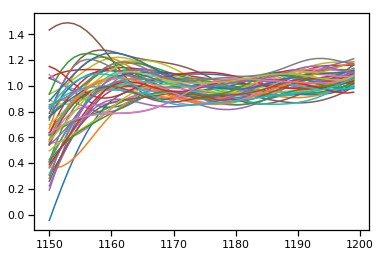

In [22]:
ax = plt.plot(x[x[:,1] < 1200,1],f_hat_test);
h = np.mean(np.sum((f_hat_test-y_test_left)**2,0))
print 'Average Error between Test set and Estimate: {:.3f}'.format(h)

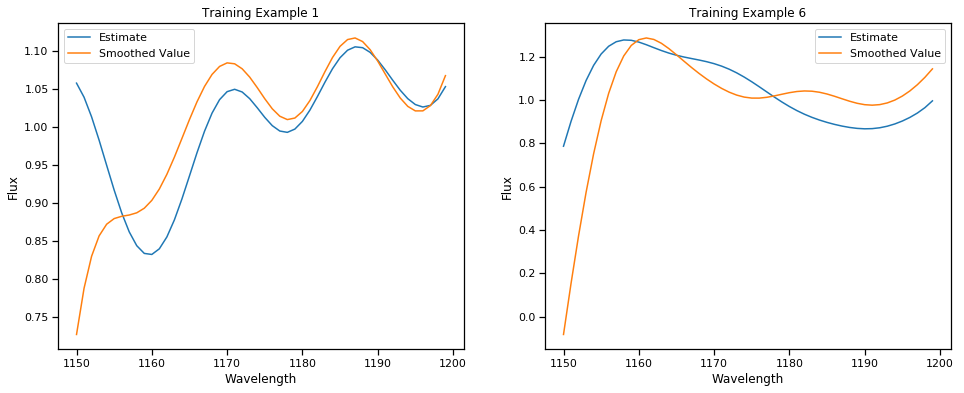

In [23]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].plot(x[x[:,1] < 1200,1],f_hat_test[:,0]);
axes[0].plot(x[x[:,1] < 1200,1],y_test_left[:,0]);
axes[0].set(xlabel='Wavelength', ylabel='Flux', title='Training Example 1');
axes[0].legend(['Estimate','Smoothed Value']);

axes[1].plot(x[x[:,1] < 1200,1],f_hat_test[:,5]);
axes[1].plot(x[x[:,1] < 1200,1],y_test_left[:,5]);
axes[1].set(xlabel='Wavelength', ylabel='Flux', title='Training Example 6');
axes[1].legend(['Estimate','Smoothed Value']);